In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import torch
from pathlib import Path

In [5]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
print(f"Model loaded successfully: {type(model)}")

Using cache found in /Users/seijimatsuda/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-22 Python-3.10.17 torch-2.6.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Model loaded successfully: <class 'models.common.AutoShape'>


## Important: This is needed after loading yolo v5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

under the hood it pulls in a bunch of native libs (OpenCV, threading hooks, etc.) that can inadvertently switch off the Jupyter “inline” display backend. The fix is simply to re-enable the inline backend (or interactive mode) after you load the model. For example:

```
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
plt.ion()
```

In [6]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
plt.ion()

In [7]:
# Your images are in the current directory, not Desktop
soccer_path = Path("pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis/high_pressure")
soccer_images = list(soccer_path.glob('*.png'))
imgs = [path.as_posix() for path in soccer_images]

print(f"Found {len(soccer_images)} images in {soccer_path}")

Found 27 images in pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis/high_pressure


In [8]:
# Verify images loaded successfully
print(f"Number of images loaded: {len(imgs)}")
if imgs:
    print("✅ Images loaded successfully!")
    print(f"First image: {imgs[0]}")
else:
    print("❌ No images loaded")

Number of images loaded: 27
✅ Images loaded successfully!
First image: pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis/high_pressure/High_00-55-17.png


In [9]:
import os
from pathlib import Path

# Check current working directory
print(f"Current working directory: {os.getcwd()}")
print()

# Look for directories containing relevant keywords
current_path = Path('.')
all_items = list(current_path.iterdir())
print("All items in current directory:")
for item in all_items:
    print(f"  {'[DIR]' if item.is_dir() else '[FILE]'} {item.name}")

print()

# Search for any folders with Barcelona, pressure, or annotation in the name
print("Searching for relevant directories...")
for item in current_path.rglob('*'):
    if item.is_dir():
        name_lower = item.name.lower()
        if any(keyword in name_lower for keyword in ['barcelona', 'pressure', 'annotation', 'betis']):
            print(f"Found relevant directory: {item}")
            # Check if it contains PNG files
            png_count = len(list(item.glob('*.png')))
            print(f"  -> Contains {png_count} PNG files")

print()

# Look for ANY PNG files anywhere
print("Searching for PNG files...")
png_files = list(current_path.rglob('*.png'))
print(f"Found {len(png_files)} total PNG files")
if png_files:
    print("PNG file locations:")
    for png in png_files[:10]:  # Show first 10
        print(f"  - {png}")

Current working directory: /Users/seijimatsuda/sources/soccer_detectors

All items in current directory:
  [FILE] .DS_Store
  [FILE] Yolov8.ipynb
  [FILE] Yolo v5.ipynb
  [DIR] output
  [DIR] pressure_annotation_data
  [FILE] Yolo v5-high-pressure.ipynb
  [FILE] yolov5s.pt
  [DIR] output_high
  [FILE] processing_history.json
  [DIR] .ipynb_checkpoints
  [DIR] .git
  [DIR] outputs

Searching for relevant directories...
Found relevant directory: pressure_annotation_data
  -> Contains 0 PNG files
Found relevant directory: pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis
  -> Contains 0 PNG files
Found relevant directory: pressure_annotation_data/games/2025-05-20_TeamA_vs_TeamB/high_pressure
  -> Contains 0 PNG files
Found relevant directory: pressure_annotation_data/games/2025-05-20_TeamA_vs_TeamB/medium_pressure
  -> Contains 0 PNG files
Found relevant directory: pressure_annotation_data/games/2025-05-20_TeamA_vs_TeamB/low_pressure
  -> Contains 0 PNG files
Found rele

In [10]:
# 2. inference
results = model(imgs)   # replace with your files

/Users/seijimatsuda/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [11]:
# 3. render to get annotated BGR arrays
rendered = results.render()

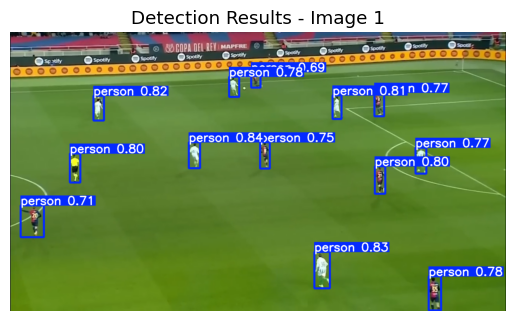

In [12]:
if len(rendered) > 0:
    plt.imshow(rendered[0])
    plt.axis('off')  # Optional: hide axes for cleaner display
    plt.title('Detection Results - Image 1')
    plt.show()
else:
    print("No results to display. Check if images were loaded correctly.")

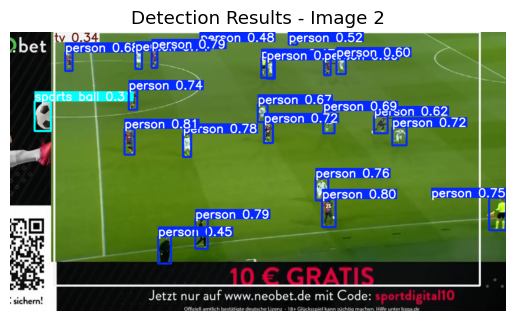

In [13]:
if len(rendered) > 1:
    plt.imshow(rendered[1])
    plt.axis('off')
    plt.title('Detection Results - Image 2')
    plt.show()
else:
    print("Second image not available.")


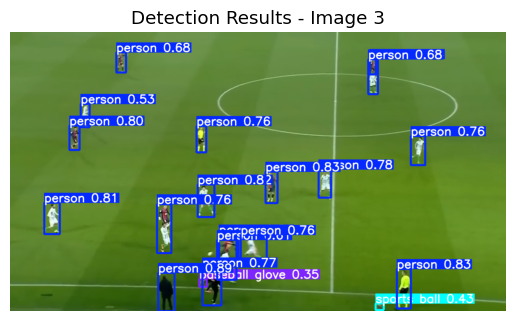

In [14]:
if len(rendered) > 2:
    plt.imshow(rendered[2])
    plt.axis('off')
    plt.title('Detection Results - Image 3')
    plt.show()
else:
    print("Third image not available.")

In [15]:
# Complete Pipeline: YOLOv5 Detection -> Save Results -> ResNet Processing

import os
import json
import csv
from pathlib import Path
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np

# ===== STEP 1: CREATE OUTPUT DIRECTORIES =====
def create_output_directories():
    """Create necessary output directories"""
    directories = [
        "output/annotated_images",
        "output/cropped_detections", 
        "output/detection_data",
        "output/resnet_features"
    ]
    
    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
    
    print("✅ Created output directories:")
    for directory in directories:
        print(f"  - {directory}")

# ===== STEP 2: EXTRACT AND SAVE YOLO RESULTS =====
def extract_and_save_yolo_results(results, imgs, output_base="output"):
    """
    Extract all detection data from YOLOv5 results and save everything
    
    Returns:
    - detection_data: List of dictionaries with all detection info
    - saved_files: Dictionary of saved file paths
    """
    detection_data = []
    saved_files = {
        'annotated_images': [],
        'cropped_detections': [],
        'detection_csvs': []
    }
    
    # Process each image result
    for img_idx, (result, img_path) in enumerate(zip(results.xyxy, imgs)):
        img_name = Path(img_path).stem
        
        # 1. SAVE ANNOTATED IMAGE
        rendered_img = results.render()[img_idx]
        annotated_path = f"{output_base}/annotated_images/{img_name}_annotated.png"
        Image.fromarray(rendered_img).save(annotated_path)
        saved_files['annotated_images'].append(annotated_path)
        
        # 2. LOAD ORIGINAL IMAGE FOR CROPPING
        original_img = Image.open(img_path)
        
        # 3. EXTRACT DETECTION DATA
        detections = result.cpu().numpy()  # Convert to numpy
        img_detections = []
        
        for det_idx, detection in enumerate(detections):
            x1, y1, x2, y2, confidence, class_id = detection
            
            # Create detection record
            detection_record = {
                'image_path': img_path,
                'image_name': img_name,
                'detection_id': det_idx,
                'x1': float(x1),
                'y1': float(y1), 
                'x2': float(x2),
                'y2': float(y2),
                'width': float(x2 - x1),
                'height': float(y2 - y1),
                'confidence': float(confidence),
                'class_id': int(class_id),
                'class_name': results.names[int(class_id)]
            }
            
            # 4. CROP AND SAVE DETECTION
            cropped_img = original_img.crop((x1, y1, x2, y2))
            crop_filename = f"{img_name}_det_{det_idx}_{detection_record['class_name']}_{confidence:.2f}.png"
            crop_path = f"{output_base}/cropped_detections/{crop_filename}"
            cropped_img.save(crop_path)
            
            detection_record['cropped_image_path'] = crop_path
            img_detections.append(detection_record)
            saved_files['cropped_detections'].append(crop_path)
        
        detection_data.extend(img_detections)
        
        # 5. SAVE DETECTION DATA AS CSV (per image)
        if img_detections:
            csv_path = f"{output_base}/detection_data/{img_name}_detections.csv"
            pd.DataFrame(img_detections).to_csv(csv_path, index=False)
            saved_files['detection_csvs'].append(csv_path)
    
    # 6. SAVE COMBINED DETECTION DATA
    if detection_data:
        # Save as CSV
        combined_csv = f"{output_base}/detection_data/all_detections.csv"
        pd.DataFrame(detection_data).to_csv(combined_csv, index=False)
        
        # Save as JSON
        combined_json = f"{output_base}/detection_data/all_detections.json"
        with open(combined_json, 'w') as f:
            json.dump(detection_data, f, indent=2)
        
        print(f"✅ Saved {len(detection_data)} detections from {len(imgs)} images")
        print(f"📁 Annotated images: {len(saved_files['annotated_images'])}")
        print(f"✂️ Cropped detections: {len(saved_files['cropped_detections'])}")
        print(f"📊 Detection data: {combined_csv}")
    
    return detection_data, saved_files

# ===== STEP 3: RESNET MODEL SETUP =====
def setup_resnet_model(model_name='resnet50', pretrained=True):
    """
    Setup ResNet model for feature extraction
    
    Available models: resnet18, resnet34, resnet50, resnet101, resnet152
    """
    import torchvision.models as models
    
    # Load pretrained ResNet
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
    elif model_name == 'resnet101':
        model = models.resnet101(pretrained=pretrained)
    elif model_name == 'resnet152':
        model = models.resnet152(pretrained=pretrained)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Remove the final classification layer to get features
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    
    # Define image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
    ])
    
    print(f"✅ Setup {model_name} model for feature extraction")
    return model, preprocess

# ===== STEP 4: PROCESS DETECTIONS THROUGH RESNET =====
def process_detections_with_resnet(detection_data, resnet_model, preprocess, output_base="output"):
    """
    Process all cropped detections through ResNet and save features
    """
    features_data = []
    
    print(f"🔄 Processing {len(detection_data)} detections through ResNet...")
    
    with torch.no_grad():
        for i, detection in enumerate(detection_data):
            try:
                # Load cropped image
                img_path = detection['cropped_image_path']
                image = Image.open(img_path).convert('RGB')
                
                # Preprocess image
                input_tensor = preprocess(image).unsqueeze(0)
                
                # Extract features
                features = resnet_model(input_tensor)
                features = features.squeeze().numpy()
                
                # Create feature record
                feature_record = {
                    'detection_id': detection['detection_id'],
                    'image_name': detection['image_name'],
                    'class_name': detection['class_name'],
                    'confidence': detection['confidence'],
                    'cropped_image_path': img_path,
                    'feature_vector': features.tolist(),  # Convert to list for JSON
                    'feature_shape': features.shape,
                    'feature_mean': float(features.mean()),
                    'feature_std': float(features.std())
                }
                
                features_data.append(feature_record)
                
                if (i + 1) % 10 == 0:
                    print(f"  Processed {i + 1}/{len(detection_data)} detections...")
                    
            except Exception as e:
                print(f"  ❌ Error processing {detection.get('cropped_image_path', 'unknown')}: {e}")
    
    # Save features data
    if features_data:
        # Save detailed features as JSON
        features_json = f"{output_base}/resnet_features/resnet_features.json"
        with open(features_json, 'w') as f:
            json.dump(features_data, f, indent=2)
        
        # Save summary as CSV (without feature vectors)
        summary_data = []
        for feature in features_data:
            summary = {k: v for k, v in feature.items() if k != 'feature_vector'}
            summary_data.append(summary)
        
        summary_csv = f"{output_base}/resnet_features/resnet_features_summary.csv"
        pd.DataFrame(summary_data).to_csv(summary_csv, index=False)
        
        # Save just the feature vectors as numpy array
        feature_vectors = np.array([f['feature_vector'] for f in features_data])
        features_npy = f"{output_base}/resnet_features/feature_vectors.npy"
        np.save(features_npy, feature_vectors)
        
        print(f"✅ Saved ResNet features for {len(features_data)} detections")
        print(f"📊 Features JSON: {features_json}")
        print(f"📊 Summary CSV: {summary_csv}")
        print(f"🔢 Feature vectors: {features_npy} (shape: {feature_vectors.shape})")
    
    return features_data

# ===== STEP 5: MAIN PIPELINE FUNCTION =====
def run_complete_pipeline(results, imgs, resnet_model_name='resnet50'):
    """
    Run the complete pipeline: YOLOv5 -> Save Results -> ResNet processing
    """
    print("🚀 Starting complete YOLOv5 to ResNet pipeline...")
    
    # Step 1: Create directories
    create_output_directories()
    
    # Step 2: Extract and save YOLO results
    detection_data, saved_files = extract_and_save_yolo_results(results, imgs)
    
    if not detection_data:
        print("❌ No detections found. Pipeline stopped.")
        return None, None, None
    
    # Step 3: Setup ResNet model
    resnet_model, preprocess = setup_resnet_model(resnet_model_name)
    
    # Step 4: Process through ResNet
    features_data = process_detections_with_resnet(detection_data, resnet_model, preprocess)
    
    print("🎉 Pipeline completed successfully!")
    
    return detection_data, features_data, saved_files

# ===== USAGE EXAMPLE =====
"""
# After you have your YOLOv5 results, run this:

# Run the complete pipeline
detection_data, features_data, saved_files = run_complete_pipeline(results, imgs, 'resnet50')

# Or run steps individually:
create_output_directories()
detection_data, saved_files = extract_and_save_yolo_results(results, imgs)
resnet_model, preprocess = setup_resnet_model('resnet50')
features_data = process_detections_with_resnet(detection_data, resnet_model, preprocess)
"""

"\n# After you have your YOLOv5 results, run this:\n\n# Run the complete pipeline\ndetection_data, features_data, saved_files = run_complete_pipeline(results, imgs, 'resnet50')\n\n# Or run steps individually:\ncreate_output_directories()\ndetection_data, saved_files = extract_and_save_yolo_results(results, imgs)\nresnet_model, preprocess = setup_resnet_model('resnet50')\nfeatures_data = process_detections_with_resnet(detection_data, resnet_model, preprocess)\n"

In [16]:
# Complete Incremental Processing System with Game Organization

import os
import json
import pickle
import shutil
from datetime import datetime, timedelta
from pathlib import Path
import pandas as pd
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# ===== PART 1: PROCESSING TRACKER =====

class ProcessingTracker:
    def __init__(self, tracker_file="processing_history.json"):
        self.tracker_file = tracker_file
        self.history = self.load_history()
    
    def load_history(self):
        """Load processing history from file"""
        if Path(self.tracker_file).exists():
            with open(self.tracker_file, 'r') as f:
                return json.load(f)
        return {
            'processed_files': {},
            'processed_games': {},
            'last_scan': None,
            'model_versions': {}
        }
    
    def save_history(self):
        """Save processing history to file"""
        with open(self.tracker_file, 'w') as f:
            json.dump(self.history, f, indent=2)
    
    def mark_file_processed(self, file_path, processing_type="yolo"):
        """Mark a file as processed"""
        file_key = str(file_path)
        if file_key not in self.history['processed_files']:
            self.history['processed_files'][file_key] = {}
        
        self.history['processed_files'][file_key][processing_type] = {
            'processed_at': datetime.now().isoformat(),
            'file_modified': os.path.getmtime(file_path)
        }
        self.save_history()
    
    def is_file_processed(self, file_path, processing_type="yolo"):
        """Check if file has been processed and is up to date"""
        file_key = str(file_path)
        
        if file_key not in self.history['processed_files']:
            return False
        
        if processing_type not in self.history['processed_files'][file_key]:
            return False
        
        # Check if file has been modified since processing
        recorded_mtime = self.history['processed_files'][file_key][processing_type]['file_modified']
        current_mtime = os.path.getmtime(file_path)
        
        return current_mtime <= recorded_mtime + 1  # 1 second tolerance
    
    def get_unprocessed_files(self, directory, file_pattern="*.png", processing_type="yolo"):
        """Get list of files that haven't been processed"""
        all_files = list(Path(directory).rglob(file_pattern))
        unprocessed = [f for f in all_files if not self.is_file_processed(f, processing_type)]
        return unprocessed

# ===== PART 2: GAME ORGANIZATION SYSTEM =====

class GameOrganizer:
    def __init__(self, base_output_dir="outputs"):
        self.base_output_dir = Path(base_output_dir)
        
    def extract_game_info(self, image_path):
        """Extract game name and pressure level from path"""
        path_parts = Path(image_path).parts
        
        # Find the game directory (contains the match name)
        game_name = None
        pressure_level = None
        
        for i, part in enumerate(path_parts):
            if 'vs' in part or 'FC_' in part:  # Match pattern
                game_name = part
                break
        
        # Find pressure level
        for part in path_parts:
            if 'pressure' in part:
                pressure_level = part.replace('_pressure', '')
                break
        
        return game_name, pressure_level
    
    def get_output_directory(self, game_name, pressure_level):
        """Get organized output directory for game and pressure level"""
        output_dir = self.base_output_dir / game_name / pressure_level
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Create subdirectories
        subdirs = ['annotated_images', 'cropped_detections', 'detection_data', 'resnet_features']
        for subdir in subdirs:
            (output_dir / subdir).mkdir(exist_ok=True)
        
        return output_dir
    
    def reorganize_existing_outputs(self):
        """Reorganize existing outputs into game-based structure"""
        print("🗂️  Reorganizing existing outputs by game...")
        
        # Define old output directories
        old_dirs = ['output_high', 'output_medium', 'output_low']
        
        for old_dir in old_dirs:
            old_path = Path(old_dir)
            if not old_path.exists():
                continue
                
            pressure_level = old_dir.replace('output_', '').replace('_pressure', '')
            
            # Move files to new structure
            # Assuming all current data is from Barcelona vs Real Betis
            game_name = "2025-01-15_FC_Barcelona_vs_Real_Betis"
            new_dir = self.get_output_directory(game_name, pressure_level)
            
            print(f"  Moving {old_dir} → {new_dir}")
            
            # Move each subdirectory
            for subdir in old_path.iterdir():
                if subdir.is_dir():
                    target_dir = new_dir / subdir.name
                    if target_dir.exists():
                        # Merge directories
                        for file in subdir.iterdir():
                            shutil.move(str(file), str(target_dir))
                        subdir.rmdir()
                    else:
                        shutil.move(str(subdir), str(target_dir))
            
            # Remove old directory if empty
            if old_path.exists() and not any(old_path.iterdir()):
                old_path.rmdir()
        
        print("✅ Reorganization complete!")

# ===== PART 3: NEW DATA SCANNER =====

class NewDataScanner:
    def __init__(self, data_root="pressure_annotation_data", tracker=None):
        self.data_root = Path(data_root)
        self.tracker = tracker or ProcessingTracker()
        self.organizer = GameOrganizer()
    
    def scan_for_new_data(self):
        """Scan for new data and organize by game/pressure"""
        print("🔍 Scanning for new data...")
        
        new_data = defaultdict(lambda: defaultdict(list))
        
        # Scan all image files
        for img_path in self.data_root.rglob("*.png"):
            if not self.tracker.is_file_processed(img_path, "yolo"):
                game_name, pressure_level = self.organizer.extract_game_info(img_path)
                if game_name and pressure_level:
                    new_data[game_name][pressure_level].append(img_path)
        
        # Convert to regular dict for easier handling
        new_data = {game: dict(pressures) for game, pressures in new_data.items()}
        
        if new_data:
            print(f"📋 Found new data in {len(new_data)} games:")
            for game, pressures in new_data.items():
                total_images = sum(len(images) for images in pressures.values())
                print(f"  🎮 {game}: {total_images} images")
                for pressure, images in pressures.items():
                    print(f"    📸 {pressure}: {len(images)} images")
        else:
            print("✅ No new data found")
        
        return new_data
    
    def confirm_processing(self, new_data):
        """Ask user to confirm processing new data"""
        if not new_data:
            return False
        
        total_images = sum(
            len(images) for game_data in new_data.values() 
            for images in game_data.values()
        )
        
        print(f"\n🤔 Process {total_images} new images? (y/n): ", end="")
        response = input().lower().strip()
        return response in ['y', 'yes', 'yeah', 'yep']

# ===== PART 4: ENHANCED PRESSURE CLASSIFIER =====

class PressureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

class ImprovedPressureClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(ImprovedPressureClassifier, self).__init__()
        
        # Use ResNet50 backbone
        self.backbone = models.resnet50(pretrained=True)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # Replace final layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

class PressureModelManager:
    def __init__(self, model_save_path="pressure_model.pth"):
        self.model_save_path = model_save_path
        self.model = None
        self.training_history = []
        self.class_names = ['Low', 'Medium', 'High']
        
        # Data transforms
        self.train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def load_existing_model(self):
        """Load existing trained model if available"""
        if Path(self.model_save_path).exists():
            try:
                self.model = ImprovedPressureClassifier()
                self.model.load_state_dict(torch.load(self.model_save_path))
                self.model.eval()
                print("✅ Loaded existing pressure model")
                return True
            except Exception as e:
                print(f"❌ Failed to load existing model: {e}")
                return False
        return False
    
    def prepare_training_data(self, detection_data_by_game):
        """Prepare training data from detection results"""
        all_paths = []
        all_labels = []
        
        pressure_to_label = {'low': 0, 'medium': 1, 'high': 2}
        
        for game, pressure_data in detection_data_by_game.items():
            for pressure, detections in pressure_data.items():
                for detection in detections:
                    if 'cropped_image_path' in detection and Path(detection['cropped_image_path']).exists():
                        all_paths.append(detection['cropped_image_path'])
                        all_labels.append(pressure_to_label[pressure])
        
        return all_paths, all_labels
    
    def train_incremental(self, new_image_paths, new_labels, epochs=10, batch_size=16):
        """Train model incrementally on new data"""
        if not new_image_paths:
            print("No new training data provided")
            return None
        
        print(f"🧠 Training on {len(new_image_paths)} new samples...")
        
        # Initialize model if not exists
        if self.model is None:
            self.model = ImprovedPressureClassifier()
        
        # Prepare data
        dataset = PressureDataset(new_image_paths, new_labels, self.train_transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        # Training loop
        self.model.train()
        epoch_losses = []
        
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            for images, labels in dataloader:
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = 100 * correct / total
            epoch_losses.append(epoch_loss)
            
            if (epoch + 1) % 3 == 0:
                print(f"  Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.1f}%")
        
        # Save model
        torch.save(self.model.state_dict(), self.model_save_path)
        print(f"✅ Model saved to {self.model_save_path}")
        
        return epoch_losses
    
    def evaluate_model(self, test_paths, test_labels):
        """Evaluate model performance with detailed metrics"""
        if self.model is None:
            print("No model to evaluate")
            return None
        
        print("📊 Evaluating model performance...")
        
        # Prepare test data
        dataset = PressureDataset(test_paths, test_labels, self.test_transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        
        # Evaluation
        self.model.eval()
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in dataloader:
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        
        # Print detailed report
        print(f"\n📈 Model Performance:")
        print(f"Overall Accuracy: {accuracy:.1%}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(all_labels, all_predictions, target_names=self.class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_predictions)
        self.plot_confusion_matrix(cm)
        
        # Per-class accuracy
        print(f"\nPer-Class Accuracy:")
        for i, class_name in enumerate(self.class_names):
            class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
            print(f"  {class_name}: {class_acc:.1%}")
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'predictions': all_predictions,
            'true_labels': all_labels
        }
    
    def plot_confusion_matrix(self, cm):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Pressure Classification Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    def predict_pressure(self, image_paths):
        """Predict pressure levels for new images"""
        if self.model is None:
            print("No model loaded")
            return None
        
        dataset = PressureDataset(image_paths, [0]*len(image_paths), self.test_transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        
        self.model.eval()
        predictions = []
        confidences = []
        
        with torch.no_grad():
            for images, _ in dataloader:
                outputs = self.model(images)
                probabilities = torch.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probabilities, 1)
                
                predictions.extend(predicted.cpu().numpy())
                confidences.extend(confidence.cpu().numpy())
        
        results = []
        for i, (pred, conf) in enumerate(zip(predictions, confidences)):
            results.append({
                'image_path': image_paths[i],
                'predicted_pressure': self.class_names[pred],
                'confidence': float(conf)
            })
        
        return results

# ===== PART 5: MAIN INCREMENTAL PROCESSING SYSTEM =====

class IncrementalProcessor:
    def __init__(self):
        self.tracker = ProcessingTracker()
        self.scanner = NewDataScanner(tracker=self.tracker)
        self.organizer = GameOrganizer()
        self.model_manager = PressureModelManager()
        
        # Initialize YOLOv5 model (assuming it's already loaded globally)
        self.yolo_model = None
    
    def set_yolo_model(self, model):
        """Set the YOLOv5 model"""
        self.yolo_model = model
    
    def process_new_data(self):
        """Main function to process all new data"""
        print("🚀 INCREMENTAL PROCESSING SYSTEM")
        print("=" * 50)
        
        # Step 1: Scan for new data
        new_data = self.scanner.scan_for_new_data()
        
        if not new_data:
            print("✅ No new data to process")
            return None
        
        # Step 2: Confirm processing
        if not self.scanner.confirm_processing(new_data):
            print("❌ Processing cancelled")
            return None
        
        # Step 3: Process with YOLOv5
        detection_results = {}
        for game_name, pressure_data in new_data.items():
            print(f"\n🎮 Processing game: {game_name}")
            detection_results[game_name] = {}
            
            for pressure_level, image_paths in pressure_data.items():
                print(f"  📸 Processing {pressure_level}: {len(image_paths)} images")
                
                # Run YOLOv5 inference
                if self.yolo_model is None:
                    print("❌ YOLOv5 model not set!")
                    continue
                
                imgs = [str(path) for path in image_paths]
                results = self.yolo_model(imgs)
                
                # Get output directory
                output_dir = self.organizer.get_output_directory(game_name, pressure_level)
                
                # Process results (using existing function)
                detection_data, saved_files = extract_and_save_yolo_results(
                    results, imgs, str(output_dir)
                )
                
                detection_results[game_name][pressure_level] = detection_data
                
                # Mark files as processed
                for img_path in image_paths:
                    self.tracker.mark_file_processed(img_path, "yolo")
        
        # Step 4: Update pressure classification model
        self.update_pressure_model(detection_results)
        
        print("\n🎉 Incremental processing complete!")
        return detection_results
    
    def update_pressure_model(self, detection_results):
        """Update pressure classification model with new data"""
        print("\n🧠 Updating pressure classification model...")
        
        # Load existing model
        self.model_manager.load_existing_model()
        
        # Prepare new training data
        new_paths, new_labels = self.model_manager.prepare_training_data(detection_results)
        
        if new_paths:
            # Train incrementally
            self.model_manager.train_incremental(new_paths, new_labels)
            
            # Evaluate on a sample
            if len(new_paths) >= 10:
                sample_size = min(len(new_paths), 50)
                indices = np.random.choice(len(new_paths), sample_size, replace=False)
                test_paths = [new_paths[i] for i in indices]
                test_labels = [new_labels[i] for i in indices]
                
                self.model_manager.evaluate_model(test_paths, test_labels)
        else:
            print("No valid detection crops found for training")
    
    def reorganize_existing_data(self):
        """Reorganize existing outputs into game-based structure"""
        self.organizer.reorganize_existing_outputs()
    
    def show_processing_status(self):
        """Show current processing status"""
        print("📊 PROCESSING STATUS")
        print("=" * 30)
        
        # Count processed files
        processed_count = len(self.tracker.history['processed_files'])
        print(f"Total processed files: {processed_count}")
        
        # Show recent activity
        if self.tracker.history.get('last_scan'):
            print(f"Last scan: {self.tracker.history['last_scan']}")
        
        # Scan for unprocessed
        unprocessed = self.tracker.get_unprocessed_files(self.scanner.data_root)
        print(f"Unprocessed files found: {len(unprocessed)}")

# ===== PART 6: CONVENIENCE FUNCTIONS =====

def setup_incremental_system():
    """Initialize the complete incremental system"""
    print("🏗️  Setting up incremental processing system...")
    
    processor = IncrementalProcessor()
    
    # Set YOLOv5 model (assuming global 'model' variable exists)
    try:
        processor.set_yolo_model(model)
        print("✅ YOLOv5 model connected")
    except NameError:
        print("⚠️  YOLOv5 model not found - make sure 'model' variable exists")
    
    return processor

def run_daily_processing():
    """Run the daily processing routine"""
    processor = setup_incremental_system()
    
    # Show status
    processor.show_processing_status()
    
    # Process new data
    results = processor.process_new_data()
    
    return processor, results

def reorganize_and_setup():
    """One-time setup: reorganize existing data and initialize system"""
    print("🔧 INITIAL SETUP")
    print("=" * 30)
    
    processor = setup_incremental_system()
    
    # Reorganize existing data
    processor.reorganize_existing_data()
    
    # Initialize tracking for existing data
    print("📝 Initializing file tracking...")
    existing_files = list(Path("pressure_annotation_data").rglob("*.png"))
    for file_path in existing_files:
        processor.tracker.mark_file_processed(file_path, "yolo")
    
    print("✅ Setup complete!")
    return processor

# ===== USAGE INSTRUCTIONS =====
"""
USAGE:

# First time setup (reorganizes existing data):
processor = reorganize_and_setup()

# Daily routine (scans for new data and processes it):
processor, results = run_daily_processing()

# Manual processing check:
processor = setup_incremental_system()
processor.show_processing_status()
results = processor.process_new_data()

# Model evaluation on existing data:
processor.model_manager.load_existing_model()
# ... prepare test data and evaluate
"""

'\nUSAGE:\n\n# First time setup (reorganizes existing data):\nprocessor = reorganize_and_setup()\n\n# Daily routine (scans for new data and processes it):\nprocessor, results = run_daily_processing()\n\n# Manual processing check:\nprocessor = setup_incremental_system()\nprocessor.show_processing_status()\nresults = processor.process_new_data()\n\n# Model evaluation on existing data:\nprocessor.model_manager.load_existing_model()\n# ... prepare test data and evaluate\n'

In [17]:
# One-time setup: reorganize existing data and initialize tracking
processor = reorganize_and_setup()

🔧 INITIAL SETUP
🏗️  Setting up incremental processing system...
✅ YOLOv5 model connected
🗂️  Reorganizing existing outputs by game...
  Moving output_high → outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/high
✅ Reorganization complete!
📝 Initializing file tracking...
✅ Setup complete!


In [18]:
# Daily routine: scan and process new data
processor, results = run_daily_processing()

🏗️  Setting up incremental processing system...
✅ YOLOv5 model connected
📊 PROCESSING STATUS
Total processed files: 161
Unprocessed files found: 0
🚀 INCREMENTAL PROCESSING SYSTEM
🔍 Scanning for new data...
✅ No new data found
✅ No new data to process


In [19]:
# Whole Image Pressure Classification System
# Trains ResNet on full images with bounding boxes to learn pressure patterns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json

class WholeImagePressureDataset(Dataset):
    def __init__(self, image_data, transform=None, add_bounding_boxes=True):
        """
        Dataset for whole images with pressure labels
        
        Args:
            image_data: List of dicts with 'image_path', 'pressure_label', 'detections'
            transform: Image transformations
            add_bounding_boxes: Whether to draw bounding boxes on images
        """
        self.image_data = image_data
        self.transform = transform
        self.add_bounding_boxes = add_bounding_boxes
    
    def __len__(self):
        return len(self.image_data)
    
    def __getitem__(self, idx):
        item = self.image_data[idx]
        
        # Load original image
        image = Image.open(item['image_path']).convert('RGB')
        
        # Draw bounding boxes if requested
        if self.add_bounding_boxes and 'detections' in item:
            image = self.draw_bounding_boxes(image, item['detections'])
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, item['pressure_label']
    
    def draw_bounding_boxes(self, image, detections):
        """Draw bounding boxes on image to highlight player positions"""
        draw = ImageDraw.Draw(image)
        
        for detection in detections:
            # Get coordinates
            x1, y1, x2, y2 = detection['x1'], detection['y1'], detection['x2'], detection['y2']
            
            # Choose color based on confidence
            confidence = detection['confidence']
            if confidence > 0.8:
                color = 'red'  # High confidence
            elif confidence > 0.5:
                color = 'orange'  # Medium confidence
            else:
                color = 'yellow'  # Lower confidence
            
            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            # Add confidence text
            text = f"{detection['class_name']} {confidence:.2f}"
            draw.text((x1, y1-15), text, fill=color)
        
        return image

class WholeImagePressureClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(WholeImagePressureClassifier, self).__init__()
        
        # Use ResNet50 backbone
        self.backbone = models.resnet50(pretrained=True)
        
        # Freeze early layers (fine-tune only later layers)
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False
        
        # Replace final classification layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate/3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

class WholeImagePressureModelManager:
    def __init__(self, model_save_path="whole_image_pressure_model.pth"):
        self.model_save_path = model_save_path
        self.model = None
        self.class_names = ['Low Pressure', 'Medium Pressure', 'High Pressure']
        
        # Data transforms - preserve spatial relationships
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize but keep aspect ratio info
            transforms.RandomHorizontalFlip(p=0.3),  # Light augmentation
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def prepare_whole_image_data(self, detection_data_high, detection_data_medium, detection_data_low):
        """Prepare whole image data with pressure labels"""
        
        print("📋 Preparing whole image training data...")
        
        # Group detections by image
        def group_detections_by_image(detection_data, pressure_label):
            image_groups = {}
            for detection in detection_data:
                img_path = detection['image_path']
                if img_path not in image_groups:
                    image_groups[img_path] = {
                        'image_path': img_path,
                        'pressure_label': pressure_label,
                        'detections': []
                    }
                image_groups[img_path]['detections'].append(detection)
            return list(image_groups.values())
        
        # Group all detection data by images
        high_images = group_detections_by_image(detection_data_high, 2)  # High = 2
        medium_images = group_detections_by_image(detection_data_medium, 1)  # Medium = 1
        low_images = group_detections_by_image(detection_data_low, 0)  # Low = 0
        
        # Combine all image data
        all_image_data = high_images + medium_images + low_images
        
        print(f"📊 Prepared image data:")
        print(f"  High pressure images: {len(high_images)}")
        print(f"  Medium pressure images: {len(medium_images)}")
        print(f"  Low pressure images: {len(low_images)}")
        print(f"  Total images: {len(all_image_data)}")
        
        # Verify images exist
        valid_image_data = []
        for item in all_image_data:
            if Path(item['image_path']).exists():
                valid_image_data.append(item)
            else:
                print(f"⚠️ Missing image: {item['image_path']}")
        
        print(f"✅ Valid images: {len(valid_image_data)}")
        return valid_image_data
    
    def train_model(self, image_data, epochs=25, batch_size=8, test_size=0.2):
        """Train the whole image pressure classification model"""
        
        if len(image_data) < 10:
            print("❌ Not enough images for training (need at least 10)")
            return None
        
        print(f"🧠 Training whole image pressure classifier on {len(image_data)} images...")
        
        # Split data
        train_data, test_data = train_test_split(
            image_data, test_size=test_size, random_state=42,
            stratify=[item['pressure_label'] for item in image_data]
        )
        
        # Create datasets
        train_dataset = WholeImagePressureDataset(train_data, self.train_transform, add_bounding_boxes=True)
        test_dataset = WholeImagePressureDataset(test_data, self.test_transform, add_bounding_boxes=True)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        self.model = WholeImagePressureClassifier(num_classes=3)
        
        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        
        # Training loop
        self.model.train()
        train_losses = []
        train_accuracies = []
        
        print(f"🔄 Training for {epochs} epochs...")
        
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            # Calculate epoch metrics
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            
            scheduler.step()
            
            # Print progress
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.1f}%")
        
        # Save model
        torch.save(self.model.state_dict(), self.model_save_path)
        print(f"✅ Model saved to {self.model_save_path}")
        
        # Plot training progress
        self.plot_training_progress(train_losses, train_accuracies)
        
        # Evaluate on test set
        test_results = self.evaluate_model(test_loader, test_data)
        
        return test_results
    
    def plot_training_progress(self, losses, accuracies):
        """Plot training progress"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss
        ax1.plot(losses, 'b-', linewidth=2)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot accuracy
        ax2.plot(accuracies, 'g-', linewidth=2)
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_loader, test_data):
        """Evaluate model and show detailed metrics"""
        
        print("\n📊 EVALUATING WHOLE IMAGE PRESSURE CLASSIFIER")
        print("=" * 60)
        
        self.model.eval()
        all_predictions = []
        all_labels = []
        all_confidences = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                probabilities = torch.softmax(outputs, dim=1)
                confidences, predicted = torch.max(probabilities, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_confidences.extend(confidences.cpu().numpy())
        
        # Calculate overall accuracy
        accuracy = accuracy_score(all_labels, all_predictions)
        
        print(f"🎯 OVERALL ACCURACY: {accuracy:.1%}")
        print(f"📈 AVERAGE CONFIDENCE: {np.mean(all_confidences):.1%}")
        
        # Detailed classification report
        print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
        print(classification_report(all_labels, all_predictions, target_names=self.class_names))
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        self.plot_confusion_matrix(cm)
        
        # Per-class accuracy breakdown
        print(f"\n🎯 PER-CLASS ACCURACY:")
        for i, class_name in enumerate(self.class_names):
            if i < len(cm) and cm[i].sum() > 0:
                class_acc = cm[i, i] / cm[i].sum()
                print(f"  {class_name}: {class_acc:.1%}")
        
        # Show some predictions with confidence
        self.show_prediction_examples(test_data, all_predictions, all_confidences, all_labels)
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'predictions': all_predictions,
            'true_labels': all_labels,
            'confidences': all_confidences
        }
    
    def plot_confusion_matrix(self, cm):
        """Plot confusion matrix heatmap"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names,
                   cbar_kws={'label': 'Number of Images'})
        plt.title('Pressure Classification Confusion Matrix\n(Full Images with Bounding Boxes)', fontsize=14)
        plt.xlabel('Predicted Pressure Level', fontsize=12)
        plt.ylabel('True Pressure Level', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def show_prediction_examples(self, test_data, predictions, confidences, true_labels, num_examples=6):
        """Show example predictions"""
        print(f"\n🖼️ PREDICTION EXAMPLES:")
        
        # Select diverse examples
        indices = np.random.choice(len(test_data), min(num_examples, len(test_data)), replace=False)
        
        for idx in indices:
            true_class = self.class_names[true_labels[idx]]
            pred_class = self.class_names[predictions[idx]]
            confidence = confidences[idx]
            correct = "✅" if true_labels[idx] == predictions[idx] else "❌"
            
            print(f"  {correct} True: {true_class} | Predicted: {pred_class} | Confidence: {confidence:.1%}")

def train_whole_image_pressure_classifier(detection_data_high, detection_data_medium, detection_data_low):
    """Main function to train whole image pressure classifier"""
    
    print("🏗️ WHOLE IMAGE PRESSURE CLASSIFICATION TRAINING")
    print("=" * 70)
    print("🎯 Goal: Learn pressure patterns from player positioning in full images")
    print("📸 Input: Full soccer images with bounding boxes drawn")
    print("🧠 Output: Pressure level classification (Low/Medium/High)")
    print()
    
    # Initialize model manager
    model_manager = WholeImagePressureModelManager()
    
    # Prepare whole image data
    image_data = model_manager.prepare_whole_image_data(
        detection_data_high, detection_data_medium, detection_data_low
    )
    
    if len(image_data) < 10:
        print("❌ Not enough unique images for training")
        print("Make sure you have processed multiple different images in each pressure category")
        return None
    
    # Train the model
    results = model_manager.train_model(image_data, epochs=30, batch_size=4)
    
    print("\n🎉 WHOLE IMAGE PRESSURE CLASSIFICATION COMPLETE!")
    print("The model has learned to recognize pressure patterns from player positioning!")
    
    return model_manager, results

# Convenience function for easy use
def run_whole_image_training():
    """Run whole image training with existing detection data"""
    
    # Check if detection data exists
    if not all(var in locals() or var in globals() for var in ['detection_data_high', 'detection_data_medium', 'detection_data_low']):
        print("❌ Detection data not found. Make sure you have:")
        print("  - detection_data_high")
        print("  - detection_data_medium") 
        print("  - detection_data_low")
        print("\nRun the original YOLOv5 pipeline first!")
        return None
    
    # Get the detection data from global scope
    global detection_data_high, detection_data_medium, detection_data_low
    
    return train_whole_image_pressure_classifier(
        detection_data_high, detection_data_medium, detection_data_low
    )

In [20]:
# STEP 1: Process all images through YOLOv5 and create detection data
print("🔄 Processing all images through original pipeline...")

# HIGH PRESSURE
print("Processing HIGH pressure images...")
soccer_path_high = Path("pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis/high_pressure")
soccer_images_high = list(soccer_path_high.glob('*.png'))
imgs_high = [path.as_posix() for path in soccer_images_high]
print(f"Found {len(imgs_high)} high pressure images")

if len(imgs_high) > 0:
    results_high = model(imgs_high)
    detection_data_high, saved_files_high = extract_and_save_yolo_results(
        results_high, imgs_high, "outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/high"
    )
else:
    detection_data_high = []

# MEDIUM PRESSURE  
print("Processing MEDIUM pressure images...")
soccer_path_medium = Path("pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis/medium_pressure")
soccer_images_medium = list(soccer_path_medium.glob('*.png'))
imgs_medium = [path.as_posix() for path in soccer_images_medium]
print(f"Found {len(imgs_medium)} medium pressure images")

if len(imgs_medium) > 0:
    results_medium = model(imgs_medium)
    detection_data_medium, saved_files_medium = extract_and_save_yolo_results(
        results_medium, imgs_medium, "outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/medium"
    )
else:
    detection_data_medium = []

# LOW PRESSURE
print("Processing LOW pressure images...")  
soccer_path_low = Path("pressure_annotation_data/games/2025-01-15_FC_Barcelona_vs_Real_Betis/low_pressure")
soccer_images_low = list(soccer_path_low.glob('*.png'))
imgs_low = [path.as_posix() for path in soccer_images_low]
print(f"Found {len(imgs_low)} low pressure images")

if len(imgs_low) > 0:
    results_low = model(imgs_low)
    detection_data_low, saved_files_low = extract_and_save_yolo_results(
        results_low, imgs_low, "outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/low"
    )
else:
    detection_data_low = []

# SUMMARY
print(f"\n✅ DETECTION PROCESSING COMPLETE!")
print(f"High pressure detections: {len(detection_data_high)}")
print(f"Medium pressure detections: {len(detection_data_medium)}")
print(f"Low pressure detections: {len(detection_data_low)}")
print("Ready for whole image training!")

🔄 Processing all images through original pipeline...
Processing HIGH pressure images...
Found 27 high pressure images


/Users/seijimatsuda/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


✅ Saved 468 detections from 27 images
📁 Annotated images: 27
✂️ Cropped detections: 468
📊 Detection data: outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/high/detection_data/all_detections.csv
Processing MEDIUM pressure images...
Found 72 medium pressure images


/Users/seijimatsuda/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


✅ Saved 1328 detections from 72 images
📁 Annotated images: 72
✂️ Cropped detections: 1328
📊 Detection data: outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/medium/detection_data/all_detections.csv
Processing LOW pressure images...
Found 62 low pressure images


/Users/seijimatsuda/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


✅ Saved 1093 detections from 62 images
📁 Annotated images: 62
✂️ Cropped detections: 1093
📊 Detection data: outputs/2025-01-15_FC_Barcelona_vs_Real_Betis/low/detection_data/all_detections.csv

✅ DETECTION PROCESSING COMPLETE!
High pressure detections: 468
Medium pressure detections: 1328
Low pressure detections: 1093
Ready for whole image training!


🎯 Starting Whole Image Pressure Classification Training
This will train ResNet on full soccer images to learn pressure from player positioning

🏗️ WHOLE IMAGE PRESSURE CLASSIFICATION TRAINING
🎯 Goal: Learn pressure patterns from player positioning in full images
📸 Input: Full soccer images with bounding boxes drawn
🧠 Output: Pressure level classification (Low/Medium/High)

📋 Preparing whole image training data...
📊 Prepared image data:
  High pressure images: 27
  Medium pressure images: 72
  Low pressure images: 62
  Total images: 161
✅ Valid images: 161
🧠 Training whole image pressure classifier on 161 images...
🔄 Training for 30 epochs...
  Epoch 5/30: Loss=1.0217, Accuracy=53.9%
  Epoch 10/30: Loss=0.7850, Accuracy=68.0%
  Epoch 15/30: Loss=0.4398, Accuracy=85.9%
  Epoch 20/30: Loss=0.5321, Accuracy=78.9%
  Epoch 25/30: Loss=0.3747, Accuracy=83.6%
  Epoch 30/30: Loss=0.4086, Accuracy=85.9%
✅ Model saved to whole_image_pressure_model.pth


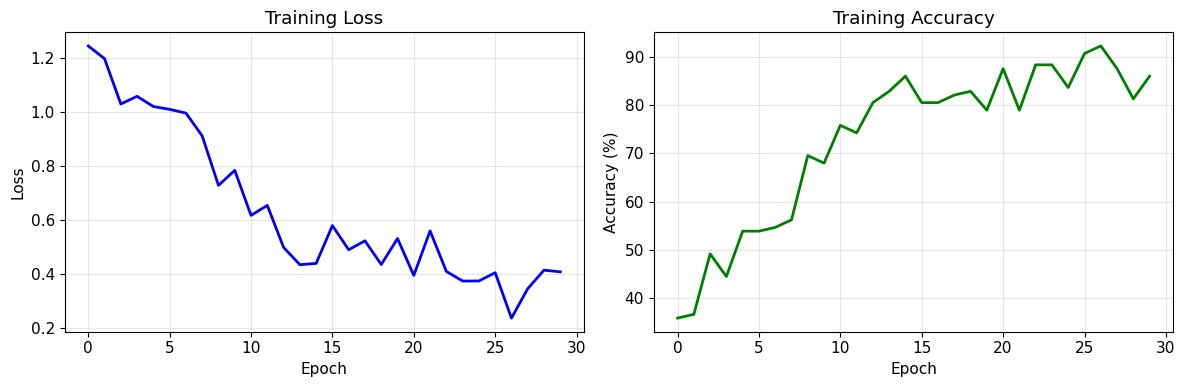


📊 EVALUATING WHOLE IMAGE PRESSURE CLASSIFIER
🎯 OVERALL ACCURACY: 45.5%
📈 AVERAGE CONFIDENCE: 73.4%

📋 DETAILED CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

   Low Pressure       0.47      0.54      0.50        13
Medium Pressure       0.50      0.47      0.48        15
  High Pressure       0.25      0.20      0.22         5

       accuracy                           0.45        33
      macro avg       0.41      0.40      0.40        33
   weighted avg       0.45      0.45      0.45        33



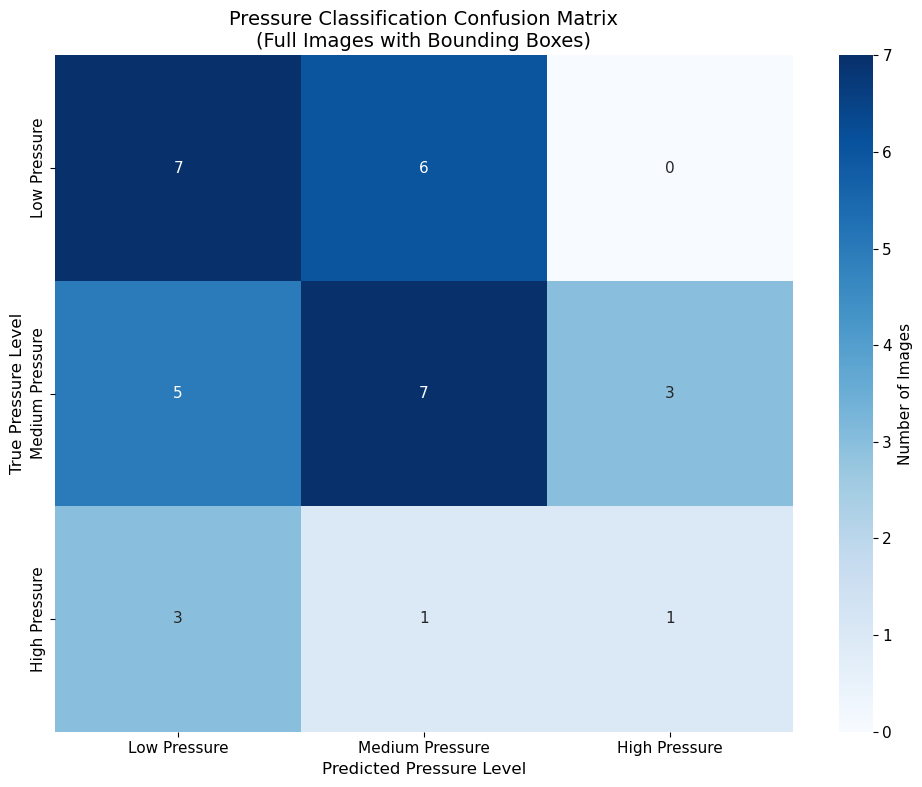


🎯 PER-CLASS ACCURACY:
  Low Pressure: 53.8%
  Medium Pressure: 46.7%
  High Pressure: 20.0%

🖼️ PREDICTION EXAMPLES:
  ❌ True: Low Pressure | Predicted: Medium Pressure | Confidence: 57.5%
  ❌ True: High Pressure | Predicted: Low Pressure | Confidence: 83.0%
  ✅ True: Low Pressure | Predicted: Low Pressure | Confidence: 65.7%
  ✅ True: Medium Pressure | Predicted: Medium Pressure | Confidence: 83.1%
  ❌ True: Medium Pressure | Predicted: Low Pressure | Confidence: 94.1%
  ❌ True: High Pressure | Predicted: Low Pressure | Confidence: 69.9%

🎉 WHOLE IMAGE PRESSURE CLASSIFICATION COMPLETE!
The model has learned to recognize pressure patterns from player positioning!


In [21]:
# Train ResNet on whole images with bounding boxes to learn pressure patterns
print("🎯 Starting Whole Image Pressure Classification Training")
print("This will train ResNet on full soccer images to learn pressure from player positioning")
print()

model_manager, results = run_whole_image_training()